# Assignment 2 - Computational Machine Learning
<b>Group Details</b> - <br>
Kunjar Supriya Rao - S3860925 <br>
Yeshaswi Aralaguppe Muralidhar - S3825856 <br>

## Research Goal
Image classification of European road traffic signs. <br>
The aim is to build and train a machine learning model to classify 28x28 gray-scale images according to - <br>
1) <b>Sign-shape </b> - diamond, hex, round, square, triangle<br>
2) <b>Sign-type </b> - stop, parking, giveway etc.

## Import the necessary libraries

In [1]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import pandas as pd
import glob
import keras
import warnings #hide deprecation warnings
from sklearn.model_selection import train_test_split #to split data into train and validation data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Using TensorFlow backend.


## Read the data

Since the task involves labelling images, its a classification problem. <br>
To read the given training data, we explore the folder structure and retrieve the labels and image names. Further, we convert all the images into grey scale and reshape it (28x28 size images). The pixel values are written out to a csv file. The image path, sign shape, sign type and flattened pixel array are read in as a pandas dataframe.

In [2]:
# Reference - https://stackoverflow.com/questions/49070242/converting-images-to-csv-file-in-python

warnings.filterwarnings('ignore') #ignore deprecation warnings

image_list = []
for filepath in glob.glob('./trafficsigns_dataset/*/*/*.png', recursive=True): #Loop through all folders
    filename = filepath.split("/")[-1]
    sign_type = filepath.split("/")[-2]
    sign_shape = filepath.split("/")[-3]

    img_file = Image.open(filepath)

    # get original image parameters
    width, height = img_file.size
    format = img_file.format
    mode = img_file.mode

    # Make image Greyscale
    img_grey = img_file.convert('L')

    # Save Greyscale values
    value = np.asarray(img_grey.getdata(), dtype=np.int).reshape((img_grey.size[1], img_grey.size[0]))
    value = value.flatten()
    with open("img_pixels.csv", 'a') as f:
        writer = csv.writer(f)
        writer.writerow(value)
    
    image_list.append((filepath, sign_shape, sign_type, value))

# Create a data frame
data = pd.DataFrame(data=image_list, columns=['image_path', 'sign_shape', 'sign_type', 'flattened array'])

Lets take a look at the dataframe

In [3]:
data.sample(5) #Show random 5 observations

,image_path,sign_shape,sign_type,flattened array
3181,./trafficsigns_dataset/round/noparking/01025_0...,round,noparking,"[48, 52, 44, 59, 58, 53, 77, 68, 63, 64, 78, 1..."
3087,./trafficsigns_dataset/round/noparking/01729_0...,round,noparking,"[78, 63, 54, 48, 41, 38, 41, 48, 50, 50, 56, 6..."
1996,./trafficsigns_dataset/round/traveldirection/0...,round,traveldirection,"[124, 138, 138, 167, 175, 175, 164, 122, 148, ..."
1818,./trafficsigns_dataset/triangle/warning/00769_...,triangle,warning,"[136, 43, 66, 75, 80, 77, 94, 208, 225, 239, 2..."
824,./trafficsigns_dataset/square/continue/01280_0...,square,continue,"[237, 254, 254, 108, 105, 255, 255, 255, 254, ..."


In [4]:
data.shape

(3699, 4)

In [5]:
print(data['flattened array'][0].shape)
print(data['flattened array'][345].shape)

(784,)
(784,)


Check for any null values

In [6]:
print(data['sign_shape'].value_counts())
print(data['sign_shape'].value_counts().count())

round       1760
triangle     926
square       688
diamond      282
hex           43
Name: sign_shape, dtype: int64
5


In [7]:
print(data['sign_type'].value_counts())
print(data['sign_type'].value_counts().count())

warning             695
noentry             375
speed               316
bicycle             285
rightofway          282
parking             276
noparking           242
giveway             231
continue            199
trafficdirective    195
limitedtraffic      125
traveldirection     124
laneend             118
roundabout           98
crossing             95
stop                 43
Name: sign_type, dtype: int64
16


In [8]:
pd.isna(data).sum()

image_path         0
sign_shape         0
sign_type          0
flattened array    0
dtype: int64

<b>Observations:</b> <br>
1) We have 3699 images in our data set <br>
2) All images are scaled to 28x28 size images, and flattened array is a row vector of length 784 (28*28)<br>
3) We have 5 sign shapes - round, triangle, square, diamond and hex <br>
4) There are 16 sign types <br>
5) No null values <br>

## Exploratory Data Analysis

We plot a histogram to check the distribution of the data and check the frequencies.

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3699 entries, 0 to 3698
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   image_path       3699 non-null   object
 1   sign_shape       3699 non-null   object
 2   sign_type        3699 non-null   object
 3   flattened array  3699 non-null   object
dtypes: object(4)
memory usage: 115.7+ KB


<AxesSubplot:>

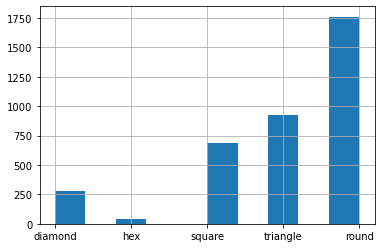

In [10]:
data.sign_shape.hist()

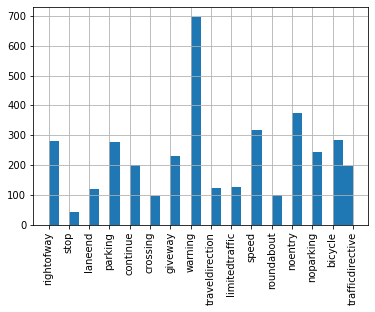

In [11]:
data.sign_type.hist(bins=30)
plt.xticks(rotation='vertical')
plt.show()

Lets randomnly, plot 4 images

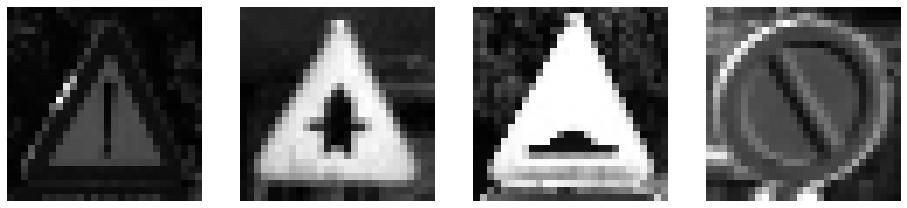

In [12]:
r_inx = np.random.choice(3699, 4)
rand_data = data.loc[r_inx,'image_path']

plt.figure(figsize=(16,4))
for i, image_path in enumerate(rand_data):
    im = np.asarray(Image.open(image_path))
    plt.subplot(1,4,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
plt.show()

<b>Observations:</b> <br>
1) The dataset is highly imbalanced as observed from the histogram plots <br>
2) The training samples for categories - hex, stop, laneend, crossing, traveldirection, limitedtraffic and roundabout are relatively very less. <br>
3) Successfully retrieved grey scale images.

## Image encoding
For later processing we map the string labels to numeric values.

In [13]:
d = {'rightofway':0, 'stop':1, 'bicycle':2, 'limitedtraffic':3, 'noentry':4, 'noparking':5, 'roundabout':6, 'speed':7, 'trafficdirective':8, 'traveldirection':9,  'continue':10, 'crossing':11, 'laneend':12, 'parking':13, 'giveway':14, 'warning':15}
data['sign_type_num'] = data['sign_type'].map(d, na_action='ignore')

In [14]:
d = {'diamond':0, 'hex':1, 'square':2, 'triangle':3, 'round':4}
data['sign_shape_num'] = data['sign_shape'].map(d, na_action='ignore')

In [15]:
data.dtypes

image_path         object
sign_shape         object
sign_type          object
flattened array    object
sign_type_num       int64
sign_shape_num      int64
dtype: object

## Model development 
The given problem falls under the supervised learning technique, and is an image classification problem.
Next, we explore the evaluation/performance metrics and build the model.

### Evaluation metrics

In our case, model accuracy might not be a good evaluation metric as the dataset is imbalanced and might lead to poor performance through wrong inferences.

Hence, we choose f1 score, which is the harmonic mean of recall and precision, to get an idea of how well our model performs.
Further, for this task, we will use **macro f1_score** as the performance measure since
 - its an imbalanced dataset and the target class is heavily biased to few classes.
 - we would like to give equal importance to all the classes and see similar performance.


In [16]:
x=pd.read_csv("img_pixels.csv", header=None)

In [17]:
y=data['sign_shape_num']

In [18]:
x_train, x_val, y_train, y_val = train_test_split(x,y,random_state=0, stratify=data['sign_shape_num'])
clf=LogisticRegression(class_weight='balanced')
fit=clf.fit(x_train,y_train)
pred=fit.predict(x_val)
confusion_matrix(y_val, pred)

array([[ 65,   0,   0,   2,   3],
       [  0,   9,   1,   1,   0],
       [  0,   0, 161,   4,   7],
       [  4,   0,   7, 211,  10],
       [  4,   0,   3,   8, 425]])

In [19]:
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91        70
           1       1.00      0.82      0.90        11
           2       0.94      0.94      0.94       172
           3       0.93      0.91      0.92       232
           4       0.96      0.97      0.96       440

    accuracy                           0.94       925
   macro avg       0.94      0.91      0.93       925
weighted avg       0.94      0.94      0.94       925



In [20]:
def get_f1_scores(clf, train_X, train_y, val_X, val_y):
    train_pred = clf.predict(train_X)
    val_pred = clf.predict(val_X)

    train_f1 = f1_score(train_y, train_pred, average='macro')
    val_f1 = f1_score(val_y, val_pred, average='macro')

    return train_f1, val_f1

In [21]:
train_f1, val_f1 = get_f1_scores(clf, x_train, y_train, x_val, y_val)
print("Training F1 score - ",train_f1)
print("Validation F1 score - ",val_f1)

Training F1 score -  1.0
Validation F1 score -  0.9253973556065219


Next we perform the classification for sign_type

In [22]:
y=data['sign_type_num']

In [23]:
x_train, x_val, y_train, y_val = train_test_split(x,y,random_state=0, stratify=data['sign_type_num'])

In [24]:
fit=clf.fit(x_train,y_train)
pred=fit.predict(x_val)
confusion_matrix(y_val, pred)

array([[ 63,   0,   0,   1,   2,   2,   0,   0,   0,   0,   0,   0,   0,
          1,   0,   2],
       [  0,  10,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,  70,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   1],
       [  1,   0,   0,  29,   0,   0,   0,   0,   0,   1,   0,   0,   0,
          0,   0,   0],
       [  1,   0,   2,   0,  81,   4,   0,   0,   0,   1,   0,   0,   0,
          0,   4,   1],
       [  2,   0,   2,   1,   2,  52,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   1],
       [  0,   0,   0,   0,   0,   0,  24,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  76,   1,   0,   0,   0,   0,
          1,   0,   1],
       [  0,   0,   0,   2,   1,   0,   0,   0,  45,   0,   0,   0,   0,
          1,   0,   0],
       [  0,   0,   1,   0,   0,   0,   0,   0,   0,  29,   0,   0,   0,
          0,   1,   0],
       [  1,   0,   0,   0,   

In [25]:
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90        71
           1       1.00      0.91      0.95        11
           2       0.88      0.99      0.93        71
           3       0.85      0.94      0.89        31
           4       0.93      0.86      0.90        94
           5       0.84      0.87      0.85        60
           6       1.00      1.00      1.00        24
           7       1.00      0.96      0.98        79
           8       0.98      0.92      0.95        49
           9       0.94      0.94      0.94        31
          10       1.00      0.92      0.96        50
          11       1.00      0.92      0.96        24
          12       1.00      1.00      1.00        29
          13       0.96      0.99      0.97        69
          14       0.90      0.98      0.94        58
          15       0.95      0.95      0.95       174

    accuracy                           0.94       925
   macro avg       0.95   

In [26]:
train_f1, val_f1 = get_f1_scores(clf, x_train, y_train, x_val, y_val)
print("Training F1 score - ",train_f1)
print("Validation F1 score - ",val_f1)

Training F1 score -  1.0
Validation F1 score -  0.9414091786929182


The gap in training and validation scores indicate overfitting.

We proceed to explore other models like Neural networks.

In [44]:
# lambda_paras = np.logspace(-1, 1, num=5)    #establish the lambda values to test (grid)

# # Perform the search
# train_performace = list()
# valid_performace = list()

# for lambda_para in lambda_paras:
#     clf = LogisticRegression(penalty='l2', C = 1.0/lambda_para, 
#                              random_state=0, solver='liblinear', max_iter=1000 , 
#                              class_weight='balanced').fit(x_train, y_train.ravel())
    
#     train_f1, val_f1 = get_f1_scores(clf, x_train, y_train, x_val, y_val)
    
#     train_performace.append(train_f1)
#     valid_performace.append(val_f1)

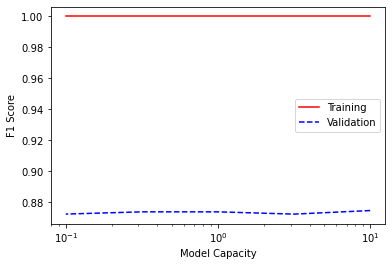

In [45]:
# plt.plot([1.0/lambda_para for lambda_para in lambda_paras], 
#          [tp for tp in train_performace], 'r-')
# plt.plot([1.0/lambda_para for lambda_para in lambda_paras], 
#          [vp for vp in valid_performace], 'b--')
# plt.xscale("log")
# plt.ylabel('F1 Score')
# plt.xlabel('Model Capacity')
# plt.legend(['Training','Validation'])
# plt.show()

In [36]:
train_x, val_x, train_y, val_y = train_test_split(data['image_path'], data['sign_shape_num'], test_size=0.2, stratify=data['sign_shape_num'])

In [37]:
train_x.shape

(2959,)

In [38]:
val_x.shape

(740,)

In [39]:
train_y.shape

(2959,)

In [40]:
val_y.shape

(740,)

<AxesSubplot:>

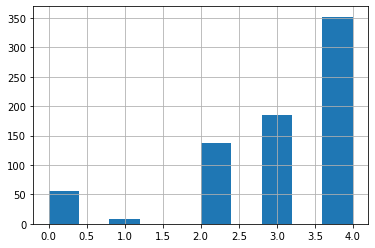

In [41]:
val_y.hist()

<AxesSubplot:>

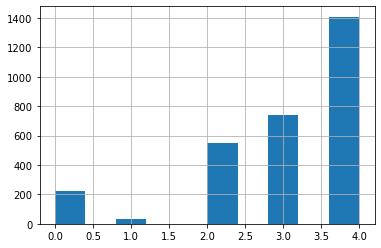

In [58]:
train_y.hist()

In [85]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

## Base Model
We choose a Multi Layer Perceptron as our base model. In this network let’s set the hidden layer dimension to 256. This is a hyper parameter and we can tune it later.

In [70]:
INPUT_DIM = (28,28,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 5

In [71]:
warnings.filterwarnings('ignore')
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [72]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               602368    
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1285      
Total params: 603,653
Trainable params: 603,653
Non-trainable params: 0
_________________________________________________________________


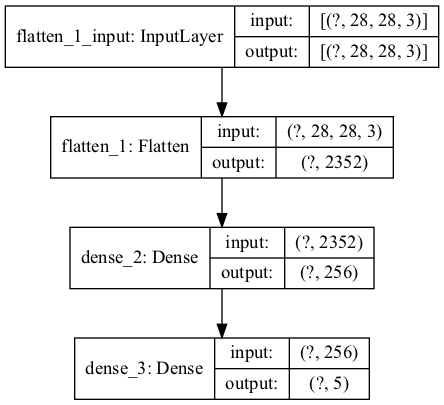

In [73]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [31]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [74]:
# model.compile(optimizer='SGD',
#               loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy', f1_score, precision_m, recall_m]
#               metrics=['categorical_accuracy'])


model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['categorical_crossentropy'])

In [60]:
# #NEW
# class ModelMetrics(tf.keras.callbacks.Callback):

#   def on_train_begin(self,logs={}):
#     self.precisions=[]
#     self.recalls=[]
#     self.f1_scores=[]
#   def on_epoch_end(self, batch, logs={}):

#     y_val_pred=self.model.predict_classes(x_val)

#     _precision,_recall,_f1,_sample=score(y_val,y_val_pred)  

#     self.precisions.append(_precision)
#     self.recalls.append(_recall)
#     self.f1_scores.append(_f1)

In [75]:
# train_df = pd.DataFrame(data=train_data, columns=['image_path', 'label'])
train_df = pd.DataFrame()
train_df['image_path']=train_x.to_frame()
train_df['sign_shape_num']=train_y.to_frame()

In [76]:
train_df.head()

,image_path,sign_shape_num
1532,./trafficsigns_dataset/triangle/warning/00965_...,3
714,./trafficsigns_dataset/square/parking/00010_00...,2
936,./trafficsigns_dataset/square/crossing/00790_0...,2
2112,./trafficsigns_dataset/round/limitedtraffic/00...,4
2164,./trafficsigns_dataset/round/limitedtraffic/01...,4


In [77]:
val_df = pd.DataFrame()
val_df['image_path']=val_x.to_frame()
val_df['sign_shape_num']=val_y.to_frame()

In [78]:
val_df.head()

,image_path,sign_shape_num
3443,./trafficsigns_dataset/round/bicycle/00171_000...,4
1689,./trafficsigns_dataset/triangle/warning/00294_...,3
2947,./trafficsigns_dataset/round/noentry/00697_000...,4
199,./trafficsigns_dataset/diamond/rightofway/0150...,0
1972,./trafficsigns_dataset/round/traveldirection/0...,4


In [79]:
train_df.to_csv('TrainData.csv')
val_df.to_csv('ValData.csv')

In [81]:
train_df['sign_shape_num']=train_df['sign_shape_num'].astype(str)
val_df['sign_shape_num']=val_df['sign_shape_num'].astype(str)

In [82]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory='./',
        x_col="image_path",
        y_col="sign_shape_num",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        directory='./',
        x_col="image_path",
        y_col="sign_shape_num",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 2959 validated image filenames belonging to 5 classes.
Found 740 validated image filenames belonging to 5 classes.


In [69]:
# history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=100, verbose=0)

In [83]:
history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=3, verbose=1)

Epoch 1/3
93/93 [==============================] - 8s 87ms/step - loss: 1.2018 - categorical_crossentropy: 14.3699 - val_loss: 1.1344 - val_categorical_crossentropy: 14.6724
Epoch 2/3
93/93 [==============================] - 8s 88ms/step - loss: 1.0909 - categorical_crossentropy: 14.7907 - val_loss: 1.0425 - val_categorical_crossentropy: 14.8347
Epoch 3/3
93/93 [==============================] - 7s 79ms/step - loss: 1.0021 - categorical_crossentropy: 14.9509 - val_loss: 0.9629 - val_categorical_crossentropy: 14.8834


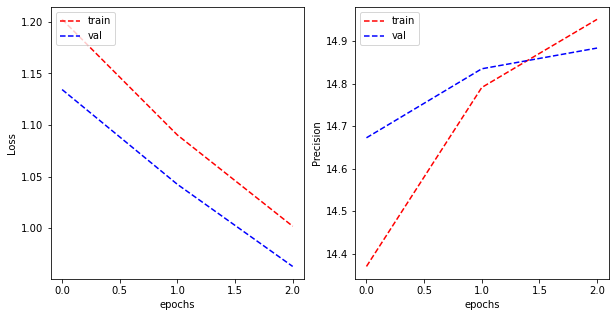

In [86]:
# plot_learning_curve(history.history['loss'], history.history['val_loss'], 
#                     history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
#                     metric_name='Accuracy')

plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_crossentropy'], history.history['val_categorical_crossentropy'], 
                    metric_name='Precision')

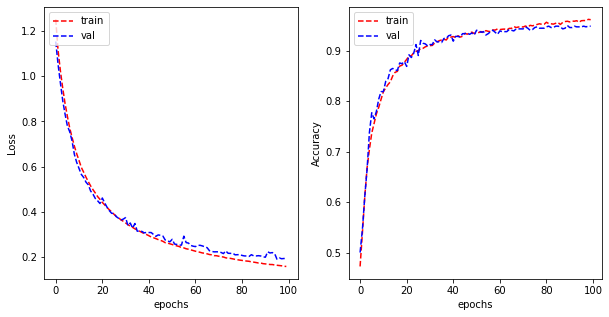

In [76]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'r--')
plt.plot(history.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['categorical_accuracy'], 'r--')
plt.plot(history.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

In [91]:
conda install -c isuruf/label/tf tensorflow-addons

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: / 
Found conflicts! Looking for incompatible packages.
This can take several minutes.  Press CTRL-C to abort.
                                                                               failed

UnsatisfiableError: The following specifications were found
to be incompatible with the existing python installation in your environment:

Specifications:

  - tensorflow-addons -> python[version='>=3.8,<3.9.0a0']

Your python: python=3.7

If python is on the left-most side of the chain, that's the version you've asked for.
When python appears to the right, that indicates that the thing on the left is somehow
not available for the python version you are constrained to. Note that conda will not
chang

In [87]:
import tensorflow_addons as tfa

ModuleNotFoundError: No module named 'tensorflow_addons'

In [78]:
# import cv2

In [79]:
# def grayscale(img):
#     image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     plt.axis('off')
#     return image

In [160]:
# csv1 = pd.read_csv("df.csv") 
# csv1.head()
# #csv1.shape

,Unnamed: 0,image_path,label,sign_type,matrix
0,0,./trafficsigns_dataset/diamond/rightofway/0003...,diamond,rightofway,[ 66 67 65 66 66 65 62 59 64 66 65 ...
1,1,./trafficsigns_dataset/diamond/rightofway/0180...,diamond,rightofway,[ 58 61 60 65 75 78 81 85 83 93 97 ...
2,2,./trafficsigns_dataset/diamond/rightofway/0170...,diamond,rightofway,[100 102 100 101 102 100 105 104 104 105 105 1...
3,3,./trafficsigns_dataset/diamond/rightofway/0011...,diamond,rightofway,[117 133 136 105 77 126 125 92 76 112 85 ...
4,4,./trafficsigns_dataset/diamond/rightofway/0123...,diamond,rightofway,[ 63 74 73 45 44 45 46 46 45 44 41 ...


In [179]:

# csv2 = pd.read_csv("img_pixels_3.csv", header=None)
# csv2.head()
# csv2['image_path']=csv1['image_path']
# #csv2.shape
# merged_data = csv1.merge(csv2,on=["image_path"])
# merged_data.shape
# #data1 = pd.read_csv("data/sheet1.csv") data1.head()

(3699, 789)

In [165]:
# merged_data.columns

Index(['Unnamed: 0', 'image_path',      'label',  'sign_type',     'matrix',
                  0,            1,            2,            3,            4,
       ...
                774,          775,          776,          777,          778,
                779,          780,          781,          782,          783],
      dtype='object', length=789)

In [163]:
# type(merged_data)

pandas.core.frame.DataFrame

In [185]:
# y= merged_data['label'].to_numpy()
# n=len(merged_data)
# #x=merged_data.drop("label", "Unnamed: 0","image_path","sign_type", "matrix", axis=1)
# x=csv2.drop("image_path", axis=1)
# # n=len(digits.images)
# # x=digits.images.reshape((n, -1))
# print(x.shape, n, y.shape)

(3699, 784) 3699 (3699,)


In [186]:
# x.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,66,67,65,66,66,65,62,59,64,66,...,22,33,32,71,87,47,52,48,52,42
1,58,61,60,65,75,78,81,85,83,93,...,112,113,114,107,98,84,72,79,83,58
2,100,102,100,101,102,100,105,104,104,105,...,63,61,60,58,54,48,47,42,39,37
3,117,133,136,105,77,126,125,92,76,112,...,113,146,191,213,213,208,208,208,197,191
4,63,74,73,45,44,45,46,46,45,44,...,139,115,93,75,46,49,57,65,71,69


In [146]:
# data.to_csv("df.csv")

In [147]:
# data.head()

,image_path,label,sign_type,matrix
0,./trafficsigns_dataset/diamond/rightofway/0003...,diamond,rightofway,"[66, 67, 65, 66, 66, 65, 62, 59, 64, 66, 65, 6..."
1,./trafficsigns_dataset/diamond/rightofway/0180...,diamond,rightofway,"[58, 61, 60, 65, 75, 78, 81, 85, 83, 93, 97, 9..."
2,./trafficsigns_dataset/diamond/rightofway/0170...,diamond,rightofway,"[100, 102, 100, 101, 102, 100, 105, 104, 104, ..."
3,./trafficsigns_dataset/diamond/rightofway/0011...,diamond,rightofway,"[117, 133, 136, 105, 77, 126, 125, 92, 76, 112..."
4,./trafficsigns_dataset/diamond/rightofway/0123...,diamond,rightofway,"[63, 74, 73, 45, 44, 45, 46, 46, 45, 44, 41, 3..."


In [98]:
# from sklearn.model_selection import train_test_split
# from sklearn.neighbors import KNeighborsClassifier
# 
# import pylab as plt
# from sklearn.datasets import load_digits
# digits = load_digits()

In [107]:
# type(data['label'])

pandas.core.series.Series

In [108]:
# len(data)

3699

In [118]:
# type(x)

numpy.ndarray

In [144]:
y= data['label'].to_numpy()
n=len(data)
x=data['matrix'].to_numpy().reshape((n,-1))
# n=len(digits.images)
# x=digits.images.reshape((n, -1))
print(x.shape, n, y.shape)

(3699, 1) 3699 (3699,)


In [139]:
# x=x.to_numpy()

In [140]:
# print(x)

[array([ 66,  67,  65,  66,  66,  65,  62,  59,  64,  66,  65,  66,  64,
         61,  63,  58,  58,  61,  60,  59,  65,  63,  57,  61,  55,  50,
         56,  47,  64,  66,  66,  63,  60,  65,  61,  64,  66,  65,  66,
         65,  63,  63,  62,  61,  57,  61,  56,  59,  59,  62,  57,  44,
         39,  40,  37,  44,  63,  60,  63,  62,  57,  55,  61,  63,  65,
         62,  66,  65,  61,  78,  68,  66,  58,  58,  58,  59,  59,  62,
         64,  63,  56,  44,  43,  37,  62,  64,  61,  60,  61,  60,  61,
         63,  66,  66,  67, 103,  41, 110, 128,  71,  47,  59,  57,  57,
         60,  65,  61,  63,  58,  40,  30,  28,  61,  66,  63,  64,  60,
         60,  63,  61,  65,  66, 113,  35, 165, 174, 173, 168,  81,  48,
         58,  60,  58,  56,  58,  60,  61,  47,  25,  24,  62,  65,  60,
         61,  63,  61,  64,  64,  65, 110,  39, 174, 171, 176, 175, 179,
        167,  75,  47,  53,  57,  59,  55,  57,  56,  46,  32,  30,  63,
         64,  63,  63,  61,  62,  62,  64,  99,  48

In [130]:
# print(x)

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]


In [196]:
# y=merged_data['sign_type'].to_numpy()

In [236]:
# y= merged_data['sign_type_num'].to_numpy()